### Method 3: ExplainSumm by Summarize Quality

In [1]:
import time
import shap
import optuna 

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from src.explainability import ExplainSumm
from src.data_visualization import visualize_metrics
from src.utils import train_test_split_comparision

from data.policy_data import policy_dict

from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# 1. Load segmented comparisons
df = pd.read_csv("data\segmentation\comparisons_segmentation.csv")

# 2. Non-features definition
comparison_columns = [
    "worker",
    "batch",
    "split",
    "id",
    "source",
    "subsource",
    "title",
    "text",
    "summary_0",
    "policy_0",
    "note_0",
    "summary_1",
    "policy_1",
    "note_1",
    "confidence",
    "ref_summary",
    "choice",
]

# 3. Target
target = ["choice"]

In [4]:
df.groupby("Quality").count()

,worker,batch,split,id,source,subsource,title,text,summary_0,policy_0,note_0,summary_1,policy_1,note_1,confidence,choice,ref_summary,m0_rouge_1_f,m0_rouge_2_f,m0_rouge_l_f,m1_rouge_1_f,m1_rouge_2_f,m1_rouge_l_f,m0_bleu,m1_bleu,m0_flesch_reading_ease,m0_syllable_count,m0_lexicon_count,m0_sentence_count,m0_char_count,m0_letter_count,m0_polysyllab_count,m0_monosyllab_count,m1_flesch_reading_ease,m1_syllable_count,m1_lexicon_count,m1_sentence_count,m1_char_count,m1_letter_count,m1_polysyllab_count,m1_monosyllab_count,m0_compression_ratio,m0_jaccard_similarity_1,m0_jaccard_similarity_2,m1_compression_ratio,m1_jaccard_similarity_1,m1_jaccard_similarity_2,m0_text_summary_xfmr_similarity,m1_text_summary_xfmr_similarity,m0_ref_summary_xfmr_similarity,m1_ref_summary_xfmr_similarity
Quality,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
High,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4529,4548,4548,4529,4548,4548,3966,3966,3966,3966,3966,3966,3966,3966,3966,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,3966,3966
Low,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,31873,42928,42928,31852,19020,42928,35197,35197,35197,35197,35197,35197,35197,35197,35197,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,35197,35197
Medium,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,25831,27517,27517,25738,27517,27517,15347,15347,15347,15347,15347,15347,15347,15347,15347,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,15347,15347


Reducing dataset memory...
Mem. usage decreased to  8.15 Mb (52.2% reduction)


[I 2023-07-13 00:36:18,589] A new study created in memory with name: no-name-30b0ca47-778e-4554-ac05-4cecb6dd29ba
[I 2023-07-13 00:36:19,778] Trial 0 finished with value: 0.38091560864976026 and parameters: {'lambda': 0.5410057246094313, 'alpha': 4.236749513702636e-07, 'subsample': 0.7733816130504156, 'colsample_bytree': 0.8666261614709038, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.2263996301295507, 'gamma': 1.446854845633667e-08}. Best is trial 0 with value: 0.38091560864976026.
[I 2023-07-13 00:36:20,657] Trial 1 finished with value: 0.37713391241441246 and parameters: {'lambda': 0.9830972167023803, 'alpha': 6.673014615439223e-07, 'subsample': 0.775370412065471, 'colsample_bytree': 0.4562556438449575, 'max_depth': 4, 'min_child_weight': 1, 'eta': 0.026723362782658272, 'gamma': 2.418634642124284e-06}. Best is trial 1 with value: 0.37713391241441246.
[I 2023-07-13 00:36:21,939] Trial 2 finished with value: 0.3842690467787774 and parameters: {'lambda': 0.3768857179621618, 'alpha':

[I 2023-07-13 00:36:52,091] Trial 21 finished with value: 0.3787062202589764 and parameters: {'lambda': 0.8439567346105185, 'alpha': 9.738401317712593e-06, 'subsample': 0.8476239541126206, 'colsample_bytree': 0.6749736727583903, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.05474906358382759, 'gamma': 2.9940549704646837e-05}. Best is trial 9 with value: 0.3706478047686077.
[I 2023-07-13 00:36:53,934] Trial 22 finished with value: 0.3742524237008034 and parameters: {'lambda': 0.7788293863135325, 'alpha': 1.4904815574170048e-06, 'subsample': 0.8656193665525148, 'colsample_bytree': 0.7136463958554087, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.06748016791414277, 'gamma': 0.00023897846827576028}. Best is trial 9 with value: 0.3706478047686077.
[I 2023-07-13 00:36:55,308] Trial 23 finished with value: 0.37347005575054687 and parameters: {'lambda': 0.9561575331668745, 'alpha': 4.1148550778716844e-05, 'subsample': 0.828805212826446, 'colsample_bytree': 0.5235363815785876, 'max_depth': 

[I 2023-07-13 00:37:17,622] Trial 42 finished with value: 0.37382698171436246 and parameters: {'lambda': 0.5700938790210577, 'alpha': 1.9671644625259325e-05, 'subsample': 0.9729868093670255, 'colsample_bytree': 0.43620120713113647, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.14921434302070094, 'gamma': 4.451758449008654e-09}. Best is trial 9 with value: 0.3706478047686077.
[I 2023-07-13 00:37:19,046] Trial 43 finished with value: 0.3735069285447382 and parameters: {'lambda': 0.6136810859122587, 'alpha': 0.00013457495120124455, 'subsample': 0.9940999073064803, 'colsample_bytree': 0.481777680638759, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.10361460415257857, 'gamma': 9.039848205719486e-09}. Best is trial 9 with value: 0.3706478047686077.
[I 2023-07-13 00:37:19,727] Trial 44 finished with value: 0.3747615299292616 and parameters: {'lambda': 0.5251594801893861, 'alpha': 0.0005353439741099309, 'subsample': 0.910943413533525, 'colsample_bytree': 0.3398550103709138, 'max_depth': 3,

Training model...
Generating predictions...
Calculate classification metrics...
Accuracy: 61.97 %
Precision: 61.35 %
Recall: 62.04 %
F1 Score: 61.69 %
ROC AUC: 61.97 %


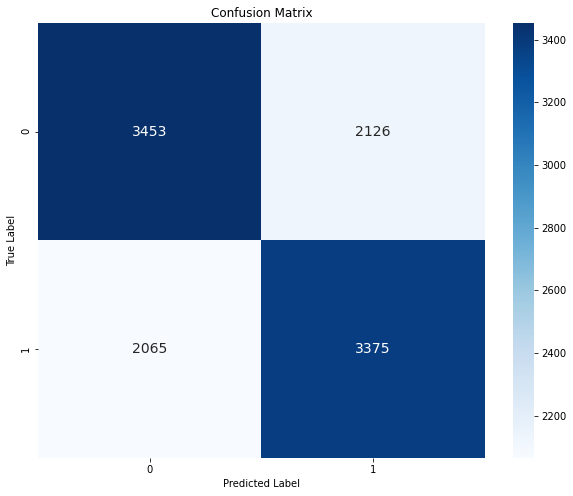

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


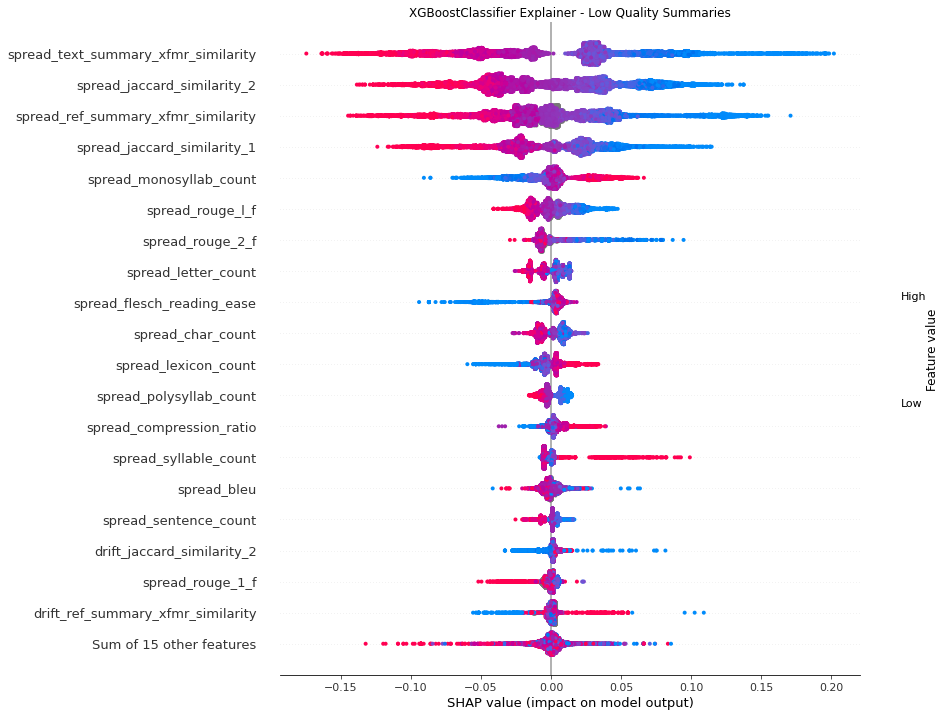

In [5]:
# SummXAI
SummXAI_low = ExplainSumm(
    df=df[df["Quality"] == "Low"].drop("Quality", axis=1),
    target=target, 
    non_features=comparison_columns,
    n_trials=50,
    n_boost_round=250,
)

# Metrics
visualize_metrics(SummXAI_low.metrics)

# Get shap values
explainer_low = shap.TreeExplainer(SummXAI_low.model)
shap_values_low = explainer_low(SummXAI_low.X_test)

# Beeswarm plot
shap.plots.beeswarm(shap_values_low, max_display=20, show=False, plot_size=(13, 12))
plt.title("XGBoostClassifier Explainer - Low Quality Summaries")

# Show the plot
plt.show()

Reducing dataset memory...
Mem. usage decreased to  5.22 Mb (52.2% reduction)


[I 2023-07-13 00:37:29,256] A new study created in memory with name: no-name-9ba14672-0ed9-4154-8a7a-e63c70c975b9
[I 2023-07-13 00:37:31,213] Trial 0 finished with value: 0.41273377473683237 and parameters: {'lambda': 0.4776204513931989, 'alpha': 0.003936473264923319, 'subsample': 0.6196127372356777, 'colsample_bytree': 0.44268745979038887, 'max_depth': 7, 'min_child_weight': 1, 'eta': 0.12191246360176018, 'gamma': 0.00018156514297855287}. Best is trial 0 with value: 0.41273377473683237.
[I 2023-07-13 00:37:32,462] Trial 1 finished with value: 0.40062022700557287 and parameters: {'lambda': 0.4786714600766446, 'alpha': 0.0004790281729304879, 'subsample': 0.9857300045792501, 'colsample_bytree': 0.29379672575318927, 'max_depth': 4, 'min_child_weight': 2, 'eta': 0.08718216907177898, 'gamma': 1.9385853643131865e-09}. Best is trial 1 with value: 0.40062022700557287.
[I 2023-07-13 00:37:33,587] Trial 2 finished with value: 0.40473623911397727 and parameters: {'lambda': 0.2766741681606036, 'al

[I 2023-07-13 00:37:59,829] Trial 21 finished with value: 0.3979507992212763 and parameters: {'lambda': 0.98676030024072, 'alpha': 2.749039620833059e-09, 'subsample': 0.6939228754271102, 'colsample_bytree': 0.43357707857092, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.019141986379874357, 'gamma': 1.218048368731858e-05}. Best is trial 21 with value: 0.3979507992212763.
[I 2023-07-13 00:38:01,406] Trial 22 finished with value: 0.4028988323458889 and parameters: {'lambda': 0.8958098279085365, 'alpha': 5.240701326377463e-06, 'subsample': 0.6317215995518211, 'colsample_bytree': 0.46205482475692666, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.020081808344769223, 'gamma': 1.7638674935898128e-05}. Best is trial 21 with value: 0.3979507992212763.
[I 2023-07-13 00:38:02,809] Trial 23 finished with value: 0.40174628392152806 and parameters: {'lambda': 0.8999285200078496, 'alpha': 7.45834208742144e-08, 'subsample': 0.706674451752029, 'colsample_bytree': 0.5762137399466559, 'max_depth': 5, 

[I 2023-07-13 00:38:32,736] Trial 42 finished with value: 0.4013828437556878 and parameters: {'lambda': 0.8371993251774976, 'alpha': 3.32497101758683e-08, 'subsample': 0.7188416037279844, 'colsample_bytree': 0.41123936241942, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.012489262486129799, 'gamma': 1.6183948495639733e-06}. Best is trial 21 with value: 0.3979507992212763.
[I 2023-07-13 00:38:33,784] Trial 43 finished with value: 0.40065180586370275 and parameters: {'lambda': 0.9438424886828176, 'alpha': 1.29128434379954e-08, 'subsample': 0.7524023168363436, 'colsample_bytree': 0.4521777791809736, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.015901421371667106, 'gamma': 3.893018541049142e-06}. Best is trial 21 with value: 0.3979507992212763.
[I 2023-07-13 00:38:35,862] Trial 44 finished with value: 0.4009933938861052 and parameters: {'lambda': 0.8607673546185942, 'alpha': 1.4963712093430965e-07, 'subsample': 0.6898729353890725, 'colsample_bytree': 0.5343948270090212, 'max_depth': 

Training model...
Generating predictions...
Calculate classification metrics...
Accuracy: 60.07 %
Precision: 60.81 %
Recall: 63.01 %
F1 Score: 61.89 %
ROC AUC: 59.98 %


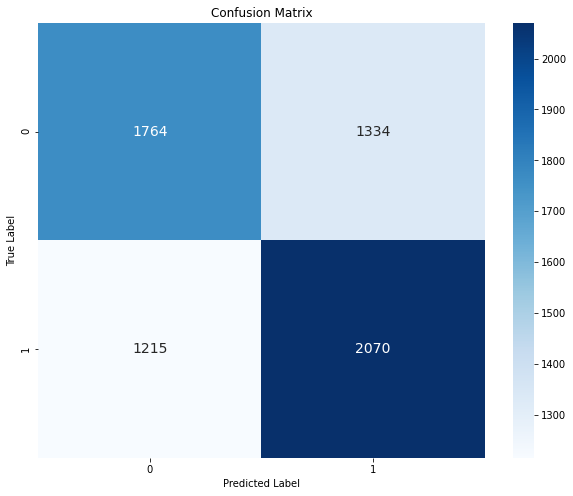

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


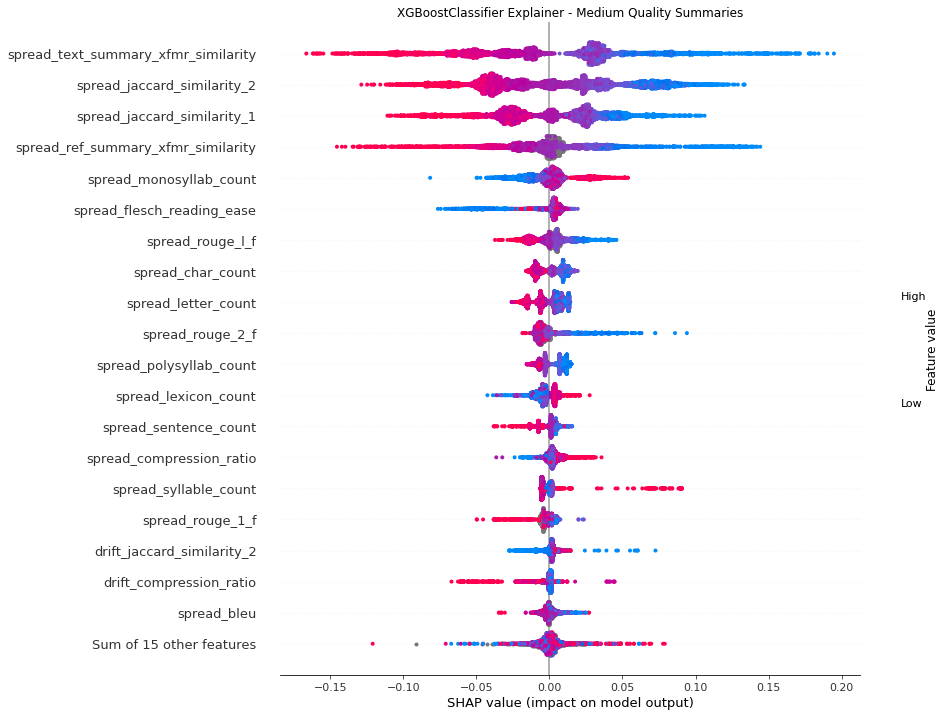

In [6]:
# SummXAI
SummXAI_medium = ExplainSumm(
    df=df[df["Quality"] == "Medium"].drop("Quality", axis=1),
    target=target, 
    non_features=comparison_columns,
    n_trials=50,
    n_boost_round=250,
)

# Metrics
visualize_metrics(SummXAI_medium.metrics)

# Get shap values
explainer_medium = shap.TreeExplainer(SummXAI_medium.model)
shap_values_medium = explainer_low(SummXAI_medium.X_test)

# Beeswarm plot
shap.plots.beeswarm(shap_values_medium, max_display=20, show=False, plot_size=(13, 12))
plt.title("XGBoostClassifier Explainer - Medium Quality Summaries")

# Show the plot
plt.show()

[I 2023-07-13 00:38:47,982] A new study created in memory with name: no-name-5552f23e-38c4-4297-8b7b-6f84396f0103


Reducing dataset memory...
Mem. usage decreased to  0.86 Mb (52.2% reduction)


[I 2023-07-13 00:38:50,093] Trial 0 finished with value: 0.4376602018664834 and parameters: {'lambda': 0.26385516268238396, 'alpha': 0.005284096692273059, 'subsample': 0.6024992022833868, 'colsample_bytree': 0.7136470488874661, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.024832091110736015, 'gamma': 0.0002751124354104201}. Best is trial 0 with value: 0.4376602018664834.
[I 2023-07-13 00:38:50,761] Trial 1 finished with value: 0.423830237603974 and parameters: {'lambda': 0.6343248144858977, 'alpha': 1.5122195584283066e-07, 'subsample': 0.7307837232367573, 'colsample_bytree': 0.797945788340593, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.010410702976350543, 'gamma': 1.0499036686907e-09}. Best is trial 1 with value: 0.423830237603974.
[I 2023-07-13 00:38:51,716] Trial 2 finished with value: 0.44441960915232437 and parameters: {'lambda': 0.40838062870429676, 'alpha': 1.7720429617524005e-06, 'subsample': 0.9180249093245354, 'colsample_bytree': 0.559076692002644, 'max_depth': 6, 'min

[I 2023-07-13 00:39:08,031] Trial 21 finished with value: 0.41988955373390474 and parameters: {'lambda': 0.8702287162784904, 'alpha': 1.24396530282637e-05, 'subsample': 0.6448377020231023, 'colsample_bytree': 0.6782240684629135, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.0811974347422168, 'gamma': 1.0608311020448274e-07}. Best is trial 14 with value: 0.41266658797688205.
[I 2023-07-13 00:39:08,795] Trial 22 finished with value: 0.41706136082976447 and parameters: {'lambda': 0.8944059846246585, 'alpha': 1.662490082105582e-05, 'subsample': 0.6400778995138027, 'colsample_bytree': 0.612145293321273, 'max_depth': 4, 'min_child_weight': 3, 'eta': 0.07279467552563317, 'gamma': 4.136484587024407e-08}. Best is trial 14 with value: 0.41266658797688205.
[I 2023-07-13 00:39:09,359] Trial 23 finished with value: 0.4285350209740807 and parameters: {'lambda': 0.996413901309481, 'alpha': 0.00011917834685233475, 'subsample': 0.6591887946754615, 'colsample_bytree': 0.5366748918023462, 'max_depth': 

[I 2023-07-13 00:39:24,730] Trial 42 finished with value: 0.4239800850947132 and parameters: {'lambda': 0.8590917875655335, 'alpha': 2.643619789176589e-05, 'subsample': 0.6315035377042768, 'colsample_bytree': 0.5572674554709756, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.05854297520488298, 'gamma': 3.921525283328756e-08}. Best is trial 14 with value: 0.41266658797688205.
[I 2023-07-13 00:39:25,262] Trial 43 finished with value: 0.41956066846419526 and parameters: {'lambda': 0.8068560308185936, 'alpha': 5.475404334987136e-06, 'subsample': 0.6873907893199254, 'colsample_bytree': 0.6498139881275544, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.06944797004126967, 'gamma': 1.2295528322460256e-08}. Best is trial 14 with value: 0.41266658797688205.
[I 2023-07-13 00:39:25,794] Trial 44 finished with value: 0.4328671056261748 and parameters: {'lambda': 0.7116983570552845, 'alpha': 6.022770483645233e-05, 'subsample': 0.7156247130804267, 'colsample_bytree': 0.5949191023193695, 'max_depth'

Training model...
Generating predictions...
Calculate classification metrics...
Accuracy: 62.14 %
Precision: 66.72 %
Recall: 60.86 %
F1 Score: 63.66 %
ROC AUC: 62.27 %


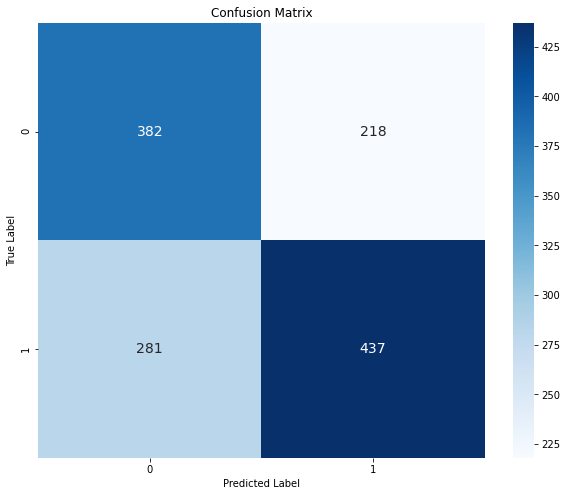

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


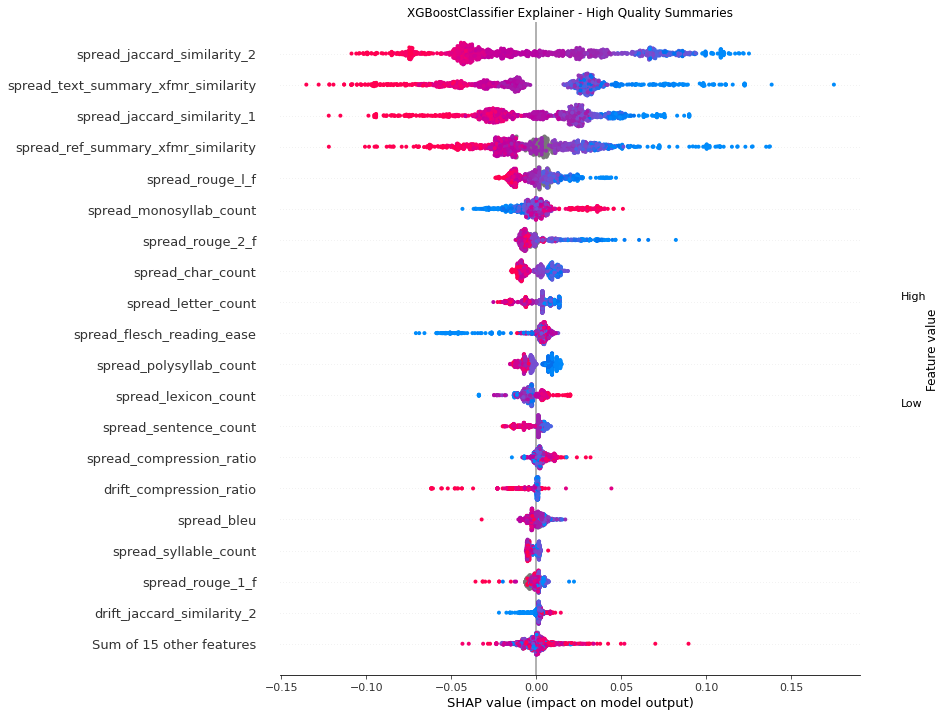

In [7]:
# SummXAI
SummXAI_high = ExplainSumm(
    df=df[df["Quality"] == "High"].drop("Quality", axis=1),
    target=target, 
    non_features=comparison_columns,
    n_trials=50,
    n_boost_round=250,
)

# Metrics
visualize_metrics(SummXAI_high.metrics)

# Get shap values
explainer_high = shap.TreeExplainer(SummXAI_high.model)
shap_values_high = explainer_low(SummXAI_high.X_test)

# Beeswarm plot
shap.plots.beeswarm(shap_values_high, max_display=20, show=False, plot_size=(13, 12))
plt.title("XGBoostClassifier Explainer - High Quality Summaries")

# Show the plot
plt.show()

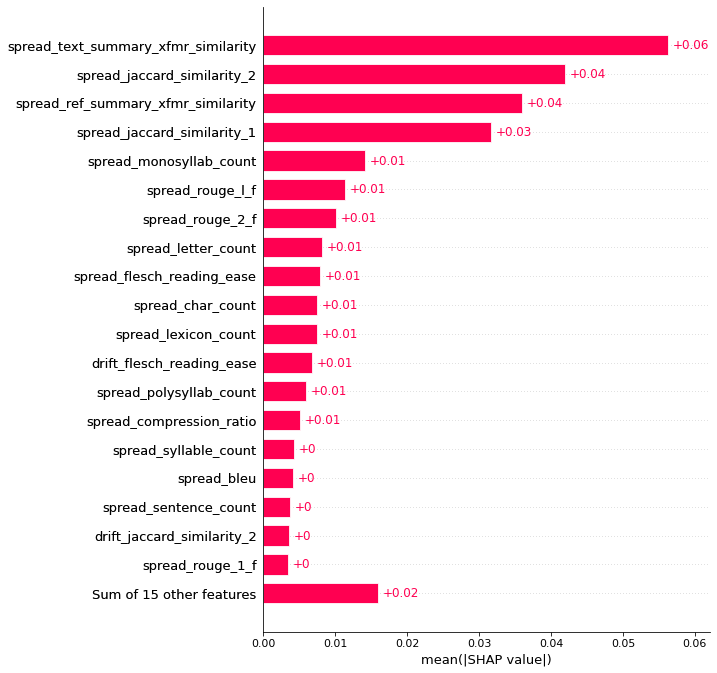

In [14]:
shap.plots.bar(shap_values_low, max_display=20, show=False)

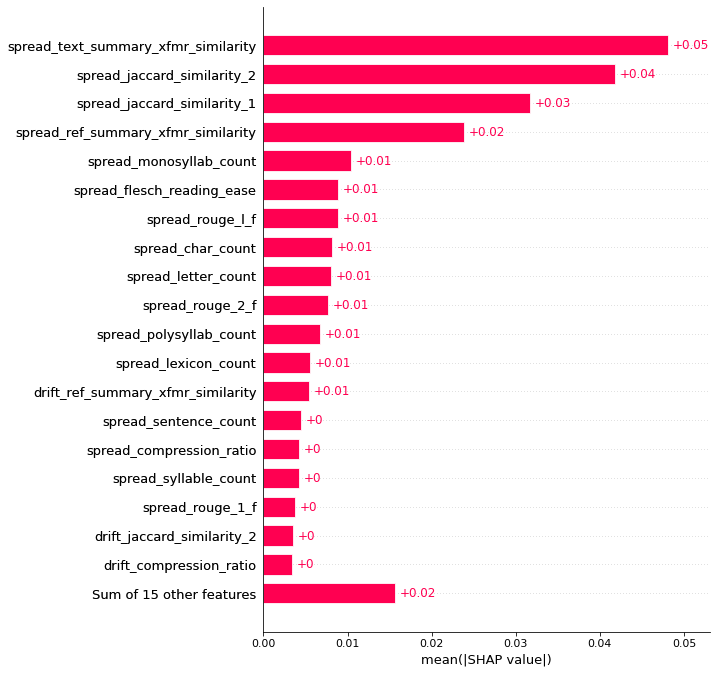

In [15]:
shap.plots.bar(shap_values_medium, max_display=20, show=False)